In [26]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from PIL import Image

In [27]:
ohio_dataset_path = "../Ohio_Manual/"
FIXED_HEIGHT = 504

In [28]:
def load_one_Bscan_from_img(path):
    img = Image.open(path)
    img = np.array(img)
    img = img.astype(np.float32)
    
    # remove the channel dimension
    img = img[:, :, 0]
    return img

def visualize_Bscan(data):
    plt.imshow(data, cmap='gray')
    plt.show()

Multiple approaches to deal with the extra portion of B scan (from now on I will call the portions that can fit within 655 $B$ and the extra portion $B'$)
1. Pad B' with the mean trace from the original B scan
2. Pad B' with the mean trace of itself
3. create a random window of size (655,655) from the scan

(504, 206)


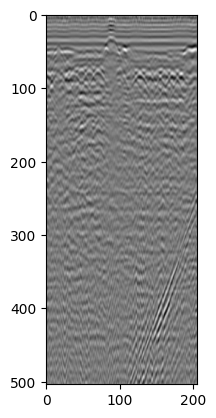

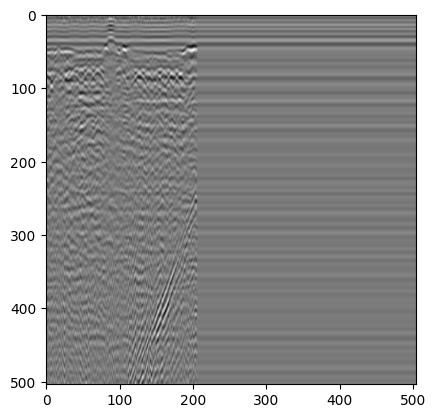

In [36]:
def pad_shorter_Bscan(data):
    """
        start with method 2
        given a B'
        pad it with the mean trace from itself
    """
    height, length = data.shape
    assert length < FIXED_HEIGHT

    pad_length = FIXED_HEIGHT - length
    mean_trace = np.mean(data, axis=1).reshape(-1, 1)
    # print(mean_trace.shape)

    # Create a padding array of the mean trace repeated pad_length times
    padding = np.tile(mean_trace, (1, pad_length))
    
    # Concatenate the padding to the original data along the second axis
    padded_data = np.concatenate((data, padding), axis=1)

    # print(padded_data.shape)

    return padded_data


def process_Bscan(data):
    """
        given a B scan np array
        crop it into more than one part if it is longer than 655
        else keep the original size
    """
    height, length = data.shape
    # print(length)
    if length > FIXED_HEIGHT:
        num = math.ceil(length/FIXED_HEIGHT)
        # print(num)
        croped_data = []

        i = 0
        while i < length:
            if length - i >= FIXED_HEIGHT:
                scan = data[:, i:i+FIXED_HEIGHT]
                croped_data.append(scan)
                i += FIXED_HEIGHT
            else:
                scan = data[:, i:]
                # need to pad the scan here to make it 655
                scan = pad_shorter_Bscan(scan)
                croped_data.append(scan)
                break
        return croped_data

    elif length < FIXED_HEIGHT:
        # need to pad the scan here to make it 655
        data = pad_shorter_Bscan(data)
        return [data]
    else:
        return [data]

data = load_one_Bscan_from_img(ohio_dataset_path + "Wet/Ohio_Section1-Scan027/Ohio_Section1-Scan027.png")
print(data.shape)
visualize_Bscan(data)
test_scans = process_Bscan(data)
for scan in test_scans:
    visualize_Bscan(scan)

# test_scans = process_Bscan(load_one_Bscan(ohio_dataset_path + "Dry/Ohio_Section4-Scan001/Ohio_Section4-Scan001.npy"))
# for scan in test_scans:
#     visualize_Bscan(scan)

In [37]:
# mass processing script
def process_sub_dataset(dir_path, save_path):
    """
        path should be either the path to Dry/
        or the path to Wet/
    """

    for path in os.listdir(dir_path):
        # only load the .npy that starts with Ohio_Section
        if path == ".DS_Store": continue
        for file in os.listdir(dir_path + path):
            if file.startswith("Ohio_Section") and file.endswith(".png") and not file.endswith("_bbox.png"):
                # print(dry_path + path + "/" + file)
                data = load_one_Bscan_from_img(dir_path + path + "/" + file)
                multiple_scans = process_Bscan(data)

                # for i, scan in enumerate(multiple_scans):
                #     # save each scan as png
                #     print(scan.shape)
                #     plt.imshow(scan, cmap='gray')
                #     plt.axis('off')
                #     plt.savefig(save_path + file[:-4] + ".png", bbox_inches='tight', pad_inches=0)
                #     plt.close()

                # dpi = 100  # Set the DPI
                # fig_size = 655 / dpi  # Calculate the figure size in inches 
                for i, scan in enumerate(multiple_scans):
                    # plt.figure(figsize=(fig_size, fig_size), dpi=dpi)  # Set the figure size and DPI
                    plt.imshow(scan, cmap='gray')
                    plt.axis('off')
                    # plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
                    # plt.margins(0, 0)
                    # plt.gca().xaxis.set_major_locator(plt.NullLocator())
                    # plt.gca().yaxis.set_major_locator(plt.NullLocator())
                    
                    # Save the figure with a tight layout
                    plt.savefig(save_path + file[:-4] + "_" + str(i) + ".png", bbox_inches='tight', pad_inches=0)
                    plt.close()


def process_dataset(path):
    """
        given a dataset path (i.e. Ohio Manual)
        process all the Bscans in the dataset
        and save them in the same directory
    """
    
    dry_path = path + "Dry/"
    normal_save_path = path + "Normal/"
    if not os.path.exists(normal_save_path):
        os.makedirs(normal_save_path)
    wet_path = path + "Wet/"
    anomalies_save_path = path + "Anomalies/"
    if not os.path.exists(anomalies_save_path):
        os.makedirs(anomalies_save_path)

    process_sub_dataset(dry_path, normal_save_path)
    process_sub_dataset(wet_path, anomalies_save_path)
    
    return



process_dataset(ohio_dataset_path)

In [42]:
# should validate two things:
# 1. the number of Bscans in each folder matches the number in the original folder
# 2. each png is FIXED_HEIGHT*FIXED_HEIGHT in dimension
PIXEL_HEIGHT = 369
CHANNEL = 4
def test_images_in_dir(dir_path):
    for img in os.listdir(dir_path):
        if img == ".DS_Store": continue
        img = Image.open(dir_path + img)
        img = np.array(img)
        # print(img.shape)
        assert img.shape == (PIXEL_HEIGHT, PIXEL_HEIGHT, CHANNEL)

def test_num_img_in_dir(new_path, orig_path):
    new_num = 0
    orig_num = 0
    for img in os.listdir(new_path):
        if img == ".DS_Store": continue
        new_num += 1
    for dir in os.listdir(orig_path):
        if dir == ".DS_Store": continue
        orig_num += 1
    print(new_num, orig_num)
    assert new_num > orig_num

test_images_in_dir(ohio_dataset_path + "Normal/")
test_images_in_dir(ohio_dataset_path + "Anomalies/")
test_num_img_in_dir(ohio_dataset_path + "Normal/", ohio_dataset_path + "Dry/")
test_num_img_in_dir(ohio_dataset_path + "Anomalies/", ohio_dataset_path + "Wet/")

227 101
1395 369
